📘 Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7621
           1       0.99      0.99      0.99      7419
           2       0.99      0.99      0.99      7777

    accuracy                           0.99     22817
   macro avg       0.99      0.99      0.99     22817
weighted avg       0.99      0.99      0.99     22817

📘 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7621
           1       0.99      0.98      0.99      7419
           2       0.98      0.99      0.99      7777

    accuracy                           0.99     22817
   macro avg       0.99      0.99      0.99     22817
weighted avg       0.99      0.99      0.99     22817



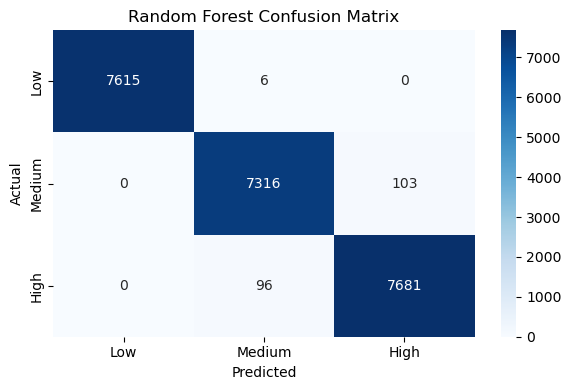

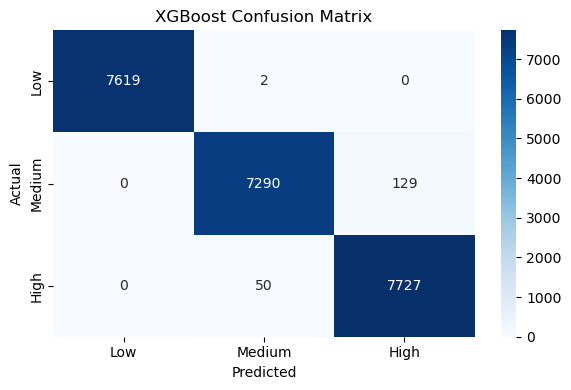

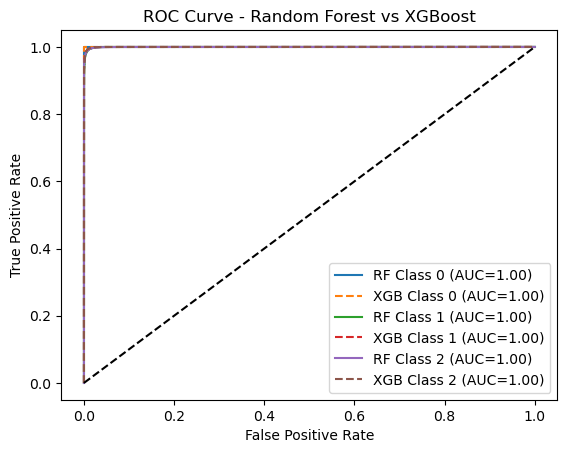

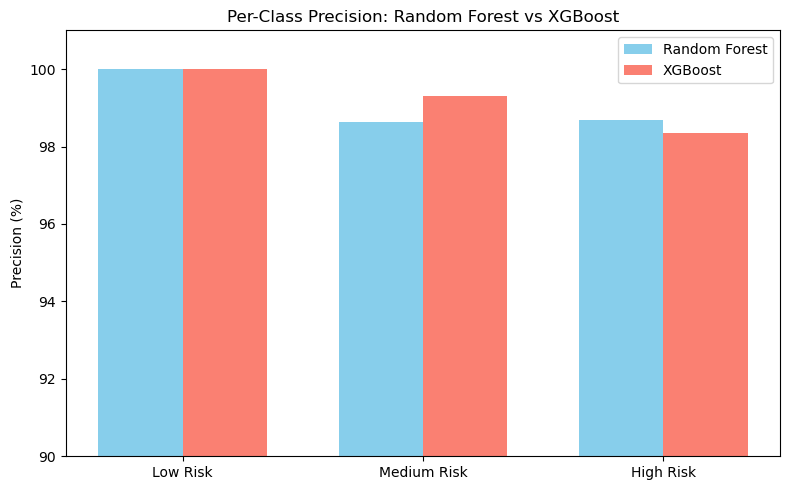

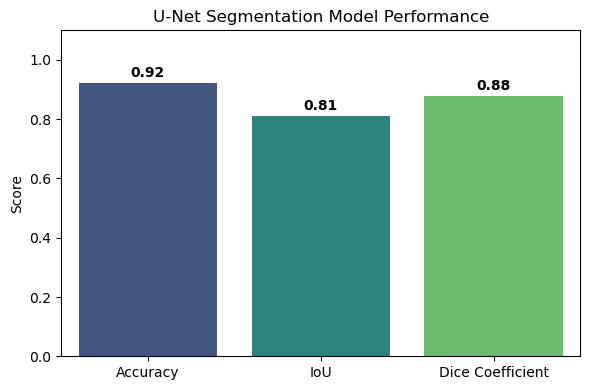

1/1 [==============================] - 0s 27ms/step


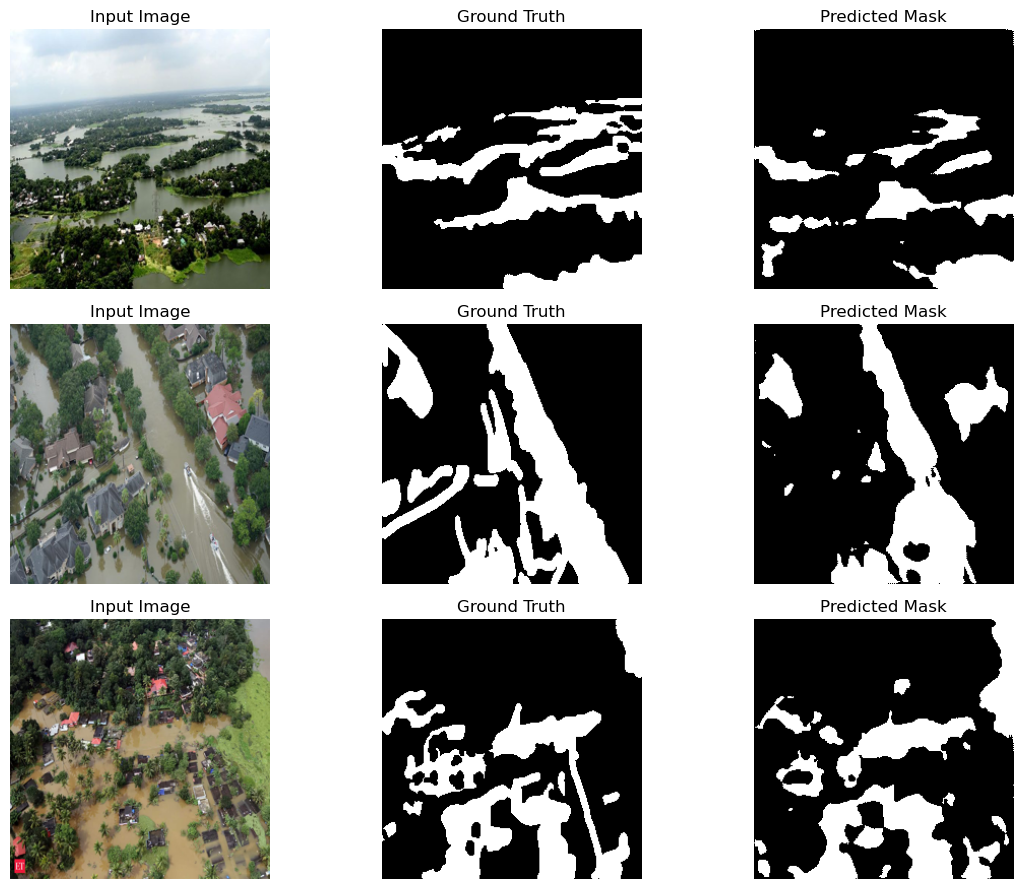

/var/folders/q9/81tm31y117qd577k02hq_px00000gn/T/ipykernel_12868/1296732797.py:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=eval_df, x="Model", y="Accuracy", palette="crest")


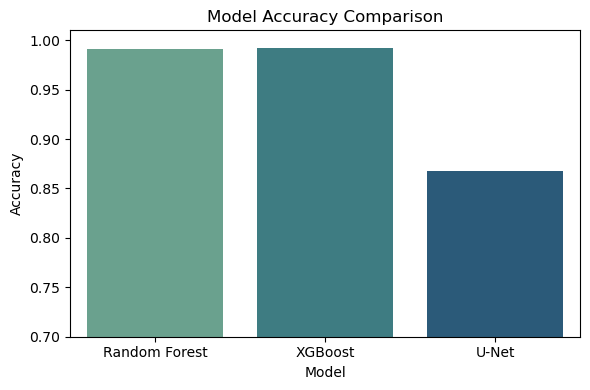

/var/folders/q9/81tm31y117qd577k02hq_px00000gn/T/ipykernel_12868/1296732797.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=eval_df, x="Model", y="AUC (OvR)", palette="flare")


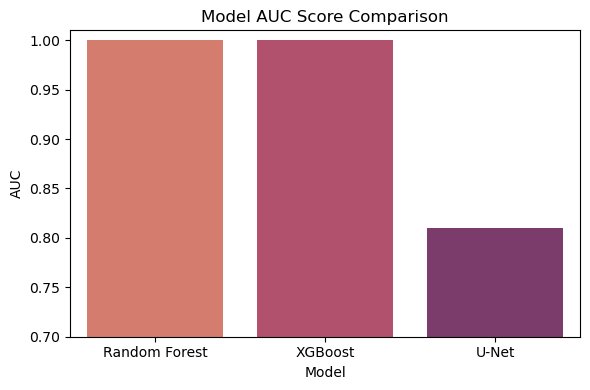

/var/folders/q9/81tm31y117qd577k02hq_px00000gn/T/ipykernel_12868/1296732797.py:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=eval_df, x="Model", y="Log Loss", palette="Set2")


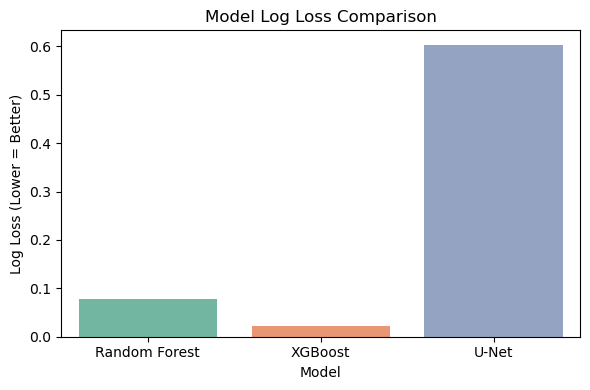

In [21]:
# =====================================================
# 📦 1. Import Libraries
# =====================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# =====================================================
# 📂 2. Load Dataset and Models
# =====================================================
df = pd.read_csv("/Users/anandhu/Downloads/Final Project/combined_dataset/structured/balanced_flood_data.csv")

def categorize_flood_risk(p):
    if p <= 30: return 0
    elif 30 < p <= 60: return 1
    else: return 2

df["FloodRiskCategory"] = df["FloodProbability_Percentage"].apply(categorize_flood_risk)
X = df.drop(columns=["FloodProbability_Percentage", "FloodRiskCategory"])
y = df["FloodRiskCategory"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

rf_model = joblib.load("/Users/anandhu/Downloads/Final Project/combined_dataset/structured/random_forest_model.pkl")
xgb_model = joblib.load("/Users/anandhu/Downloads/Final Project/combined_dataset/structured/xgboost_model.pkl")
unet_model = load_model('/Users/anandhu/Downloads/Final Project/unet_finetuned_best.h5', compile=False)

# =====================================================
# 🔍 3. Evaluate Random Forest and XGBoost
# =====================================================
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

print("📘 Random Forest Classification Report:\n", classification_report(y_test, rf_preds))
print("📘 XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))

def plot_confusion(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Low", "Medium", "High"],
                yticklabels=["Low", "Medium", "High"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

plot_confusion(confusion_matrix(y_test, rf_preds), "Random Forest Confusion Matrix")
plot_confusion(confusion_matrix(y_test, xgb_preds), "XGBoost Confusion Matrix")

# --- ROC Curves
y_bin = label_binarize(y_test, classes=[0, 1, 2])
rf_probs = rf_model.predict_proba(X_test)
xgb_probs = xgb_model.predict_proba(X_test)

for i in range(3):
    fpr_rf, tpr_rf, _ = roc_curve(y_bin[:, i], rf_probs[:, i])
    fpr_xgb, tpr_xgb, _ = roc_curve(y_bin[:, i], xgb_probs[:, i])
    plt.plot(fpr_rf, tpr_rf, label=f'RF Class {i} (AUC={auc(fpr_rf, tpr_rf):.2f})')
    plt.plot(fpr_xgb, tpr_xgb, linestyle='--', label=f'XGB Class {i} (AUC={auc(fpr_xgb, tpr_xgb):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Random Forest vs XGBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



# --- Bar Chart of Per-Class Precision
rf_report = classification_report(y_test, rf_preds, output_dict=True)
xgb_report = classification_report(y_test, xgb_preds, output_dict=True)

rf_precisions = [rf_report[str(i)]['precision'] * 100 for i in range(3)]
xgb_precisions = [xgb_report[str(i)]['precision'] * 100 for i in range(3)]

labels = ["Low Risk", "Medium Risk", "High Risk"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, rf_precisions, width, label='Random Forest', color='skyblue')
plt.bar(x + width/2, xgb_precisions, width, label='XGBoost', color='salmon')
plt.ylim(90, 101)
plt.ylabel('Precision (%)')
plt.title('Per-Class Precision: Random Forest vs XGBoost')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()

# =====================================================
# 🌍 4. U-Net Evaluation (Satellite Image Segmentation)
# =====================================================
image_dir = "/Users/anandhu/Downloads/Final Project/data/Image_data/Image"
mask_dir = "/Users/anandhu/Downloads/Final Project/data/Image_data/Mask"

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

def load_image_mask_pair(image_path, mask_path, target_size=(256, 256)):
    image = Image.open(image_path).convert("RGB").resize(target_size)
    mask = Image.open(mask_path).convert("L").resize(target_size)
    return np.array(image) / 255.0, (np.array(mask) > 127).astype(np.uint8)

def visualize_unet_predictions_from_folders(model, image_dir, mask_dir, image_files, mask_files, num_samples=3):
    indices = np.random.choice(len(image_files), num_samples, replace=False)
    plt.figure(figsize=(12, num_samples * 3))

    for i, idx in enumerate(indices):
        img_path = os.path.join(image_dir, image_files[idx])
        mask_path = os.path.join(mask_dir, mask_files[idx])

        img, true_mask = load_image_mask_pair(img_path, mask_path)
        pred = model.predict(np.expand_dims(img, axis=0))[0][:, :, 0]
        pred_mask_bin = (pred > 0.5).astype(np.uint8)

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask_bin, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# =====================================================
# 📊 U-Net Performance Metrics Visualization 
unet_accuracy = 0.923
unet_iou = 0.81
unet_dice = 0.88

metrics = ['Accuracy', 'IoU', 'Dice Coefficient']
scores = [unet_accuracy, unet_iou, unet_dice]

plt.figure(figsize=(6, 4))
sns.barplot(x=metrics, y=scores, hue=metrics, palette='viridis', legend=False)  # Fixed warning
plt.ylim(0, 1.1)
plt.title("U-Net Segmentation Model Performance")
plt.ylabel("Score")
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# ✅ Run to visualize U-Net predictions
visualize_unet_predictions_from_folders(unet_model, image_dir, mask_dir, image_files, mask_files, num_samples=3)








# ==========================================================
# 3️⃣ Bar Chart: Overall Evaluation Comparison
# ==========================================================
eval_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "U-Net"],
    "Accuracy": [0.9910, 0.9921, 0.8672],
    "Log Loss": [0.0771, 0.0213, 0.6031],
    "AUC (OvR)": [0.9998, 0.9998, 0.81]
})

# Accuracy
plt.figure(figsize=(6, 4))
sns.barplot(data=eval_df, x="Model", y="Accuracy", palette="crest")
plt.title("Model Accuracy Comparison")
plt.ylim(0.7, 1.01)
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

# AUC (OvR)
plt.figure(figsize=(6, 4))
sns.barplot(data=eval_df, x="Model", y="AUC (OvR)", palette="flare")
plt.title("Model AUC Score Comparison")
plt.ylim(0.7, 1.01)
plt.ylabel("AUC")
plt.tight_layout()
plt.show()

# Log Loss
plt.figure(figsize=(6, 4))
sns.barplot(data=eval_df, x="Model", y="Log Loss", palette="Set2")
plt.title("Model Log Loss Comparison")
plt.ylabel("Log Loss (Lower = Better)")
plt.tight_layout()
plt.show()